In [130]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
from SALib.sample import saltelli
from SALib.analyze import sobol
from lime import lime_tabular

### Read the dataset

In [131]:
df_path = '~/code/loyalist-college/sem-1/ml-1/assignment-5/Telecom.xlsx'
df = pd.read_excel(df_path, sheet_name="Telecom")

# Feature Engineering

## Remove duplicates

In [132]:
df
df.drop_duplicates()

,CustomerID,PlanTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersons,NumberOfFollowups,PlanPitched,PreferredServiceStar,MaritalStatus,NumberOfUpgrades,iPhone,PitchSatisfactionScore,PhoneContract,NumberOfChildren,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,204883,1,49.0,Self Enquiry,3,9.0,Small Business,Male,3,5.0,Deluxe,4.0,Unmarried,2.0,1,1,1,1.0,Manager,26576.0
4884,204884,1,28.0,Company Invited,1,31.0,Salaried,Male,4,5.0,Basic,3.0,Single,3.0,1,3,1,2.0,Executive,21212.0
4885,204885,1,52.0,Self Enquiry,3,17.0,Salaried,Female,4,4.0,Standard,4.0,Married,7.0,0,1,1,3.0,Senior Manager,31820.0
4886,204886,1,19.0,Self Enquiry,3,16.0,Small Business,Male,3,4.0,Basic,3.0,Single,3.0,0,5,0,2.0,Executive,20289.0


### Drop Occupation - Free Lancer

In [133]:
df = df.drop(df[df["Occupation"] == 'Free Lancer'].index)

## Select features
- Select independent features as X 
- Select dependent feature for y

In [134]:
def select_features_for_model(df):
    df = df.drop("CustomerID", axis=1)
    X = df.drop("PlanTaken", axis=1)
    y = df["PlanTaken"]
    X.info()
    return X, y

X, y = select_features_for_model(df)

<class 'pandas.core.frame.DataFrame'>
Index: 4886 entries, 0 to 4887
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     4660 non-null   float64
 1   TypeofContact           4861 non-null   object 
 2   CityTier                4886 non-null   int64  
 3   DurationOfPitch         4635 non-null   float64
 4   Occupation              4886 non-null   object 
 5   Gender                  4886 non-null   object 
 6   NumberOfPersons         4886 non-null   int64  
 7   NumberOfFollowups       4841 non-null   float64
 8   PlanPitched             4886 non-null   object 
 9   PreferredServiceStar    4860 non-null   float64
 10  MaritalStatus           4886 non-null   object 
 11  NumberOfUpgrades        4746 non-null   float64
 12  iPhone                  4886 non-null   int64  
 13  PitchSatisfactionScore  4886 non-null   int64  
 14  PhoneContract           4886 non-null   int64

## Split Train & Test

In [135]:
def split_train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_test(X, y)

## Data Cleaning

### Gender

In [136]:
# Correcting the Fe Male gender as Female
def clean_Gender(df):
    df['Gender'] = df['Gender'].map({'Male': 'Male', 'Female':'Female', 'Fe Male': 'Female'})
    return df

# Clean Train 
X_train = clean_Gender(X_train)

# Clean Test
X_test = clean_Gender(X_test)

In [137]:
# Merging Unmarried to Single
def clean_MaritalStatus(df):
    df['MaritalStatus'] = df['MaritalStatus'].map({'Married': 'Married', 
                                                  'Divorced':'Divorced', 
                                                  'Single': 'Single', 
                                                  'Unmarried': 'Single'})
    return df

# Clean Train 
X_train = clean_MaritalStatus(X_train)

# Clean Test
X_test = clean_MaritalStatus(X_test)

## Impute missing values

In [138]:
def impute_features(df):
    numeric_cols = ['DurationOfPitch', 'MonthlyIncome', 'Age', 'NumberOfUpgrades', 'NumberOfChildren', 'NumberOfFollowups', 'PreferredServiceStar']
    mean_values = df[numeric_cols].mean()
    
    df[numeric_cols] = df[numeric_cols].fillna(mean_values)
    
    categorical_cols = ['TypeofContact']
    df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

    
    return df


X_train = impute_features(X_train)

X_train.isnull().sum()

X_test = impute_features(X_test)

## Handling Outliers
* Income can be dependent on Occupation and Designation, therefore removing the outliers based on them

In [139]:
def handle_outliers(df):
    
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

    # Calculateing IQR
    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1

    # Outlier threshold - 1.5 times IQR
    threshold = 1.5

    # Finding the outliers using the threshold value
    outliers = np.logical_or(df[numeric_columns] < (Q1 - threshold * IQR), df[numeric_columns] > (Q3 + threshold * IQR))

    # Total outliers in each numerical columns
    outliers_count = outliers.sum(axis=0)
    
    columns_to_replace_with_median = ['DurationOfPitch', 'NumberOfUpgrades']
    df[columns_to_replace_with_median] = np.where(outliers[columns_to_replace_with_median], df[columns_to_replace_with_median].median(), df[columns_to_replace_with_median])
    
    # Set income thresholds based on the 95th percentile of MonthlyIncome for each designation
    thresholds_by_designation = df.groupby('Designation')['MonthlyIncome'].quantile(0.95)

    # Replace outliers based on IQR for each designation and occupation
    for (designation, occupation), group in df.groupby(['Designation', 'Occupation']):
        # Use the threshold corresponding to the designation
        income_threshold = thresholds_by_designation.get(designation, 0)

        Q1 = group['MonthlyIncome'].quantile(0.25)
        Q3 = group['MonthlyIncome'].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with the threshold value
        df.loc[(df['Designation'] == designation) & (df['Occupation'] == occupation) &
               ((df['MonthlyIncome'] < lower_bound) | (df['MonthlyIncome'] > upper_bound)),
               'MonthlyIncome'] = income_threshold
    return df

X_train = handle_outliers(X_train)

## Encoding

### PlanPitched - Ordinal encoding

In [140]:
def encode_PlanPitched(df):
    # Define the custom order
    custom_order_PlanPitched = ['Basic', 'Standard', 'Deluxe', 'Super Deluxe', 'King']

    # Initialize the OrdinalEncoder with the custom order
    encoder = OrdinalEncoder(categories=[custom_order_PlanPitched])

    # Fit and transform the labels
    df['PlanPitched'] = encoder.fit_transform(df['PlanPitched'].values.reshape(-1,1))

    return df

# Encoding on Train
X_train = encode_PlanPitched(X_train)

# Encoding on Test
X_test = encode_PlanPitched(X_test)

### Encode other categorical features

In [141]:
def encode_features(df):
    columns_to_encode = ['Gender', 'TypeofContact', 'Occupation', 'MaritalStatus', 'Designation']
    df = pd.get_dummies(df, columns=columns_to_encode)
    return df

# Encoding on Train
X_train = encode_features(X_train)

# Encoding on Test
X_test = encode_features(X_test)

### Convert scaled array back to data frame

In [142]:
def convert_ndarray_to_df(nd_array, columns):
  return pd.DataFrame(data=nd_array, columns=columns)

## Scale data

In [143]:
def scale_data(df):
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(df)
    return scaled_array


X_train_columns = X_train.columns
X_test_columns = X_train.columns

X_train_scaled_array = scale_data(X_train)
X_test_scaled_array = scale_data(X_test)

X_train = convert_ndarray_to_df(X_train_scaled_array, X_train_columns)
X_test = convert_ndarray_to_df(X_test_scaled_array, X_test_columns)

# Helpers

## Helper to display model metrics and AUC under ROC curve

In [144]:
def show_auc_under_roc(y_test, y_pred, y_prob):
    
    # Compute the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = auc(fpr, tpr)
    
    print("Accuracy: ", accuracy)
    print("Precision:", precision_score(y_test, y_pred, average="weighted"))
    print("Recall:", recall_score(y_test, y_pred, average="weighted"))
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

## Helper to display confusion matrix

In [145]:
def show_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    # Create a heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    # Add labels, title, and ticks to the plot
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix for PlanTaken")
    plt.xticks(ticks=[0, 1])  
    plt.yticks(ticks=[0, 1])

    # Show the plot
    plt.show()

### Build Logistic Regression

Accuracy: 

 0.7464212678936605
Precision: 0.8104417529594131
Recall: 0.7464212678936605


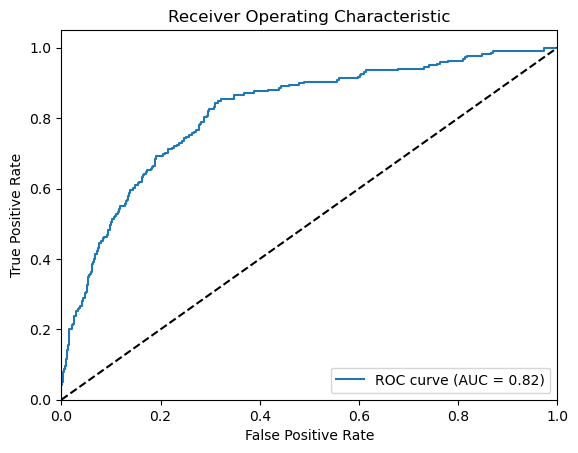

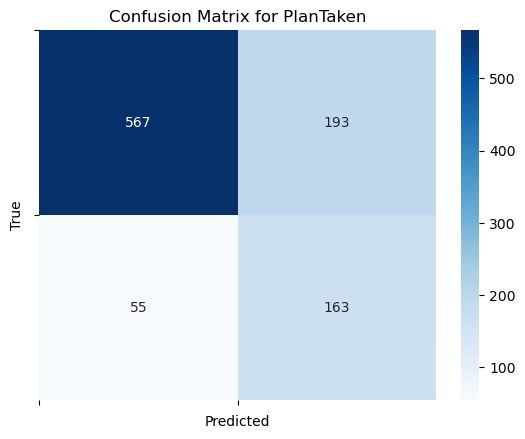

In [146]:
def build_logistic_regression_model(X_train, X_test, y_train, y_test):
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    lr_model = LogisticRegression(penalty="l2", C=13, solver="lbfgs")
    lr_model.fit(X_train_resampled, y_train_resampled)
    
    y_pred = lr_model.predict(X_test)
    y_prob = lr_model.predict_proba(X_test)[:, 1]
    
    show_auc_under_roc(y_test, y_pred, y_prob)
    show_confusion_matrix(y_test, y_pred)

    return lr_model, y_pred, y_prob
    
lr_model, y_pred_lr, y_prob_lr = build_logistic_regression_model(X_train, X_test, y_train, y_test)

### Sensitivity Analysis for Logistic Regression

In [147]:
def perform_senitivity_analysis(X, y_pred):
    N = 2 ** 10

    problem = {
        'num_vars': X.shape[1],
        'names': [f'Feature {i+1}' for i in range(X.shape[1])],
        'bounds': [[0, 1] for _ in range(X.shape[1])]
    }

    sensitivity = sobol.analyze(problem, y_pred, print_to_console=False, calc_second_order=False, conf_level=0.95)

    print("Sensitivity Analysis Results:")
    for i, feature in enumerate(problem['names']):
        print(f"{feature}: {sensitivity['S1'][i]}")

perform_senitivity_analysis(X, y_pred_lr)

RuntimeError: 
        Incorrect number of samples in model output file.
        Confirm that calc_second_order matches option used during sampling.

### Build SVM Model

Accuracy:  0.9376278118609407
Precision: 0.9369018462801489
Recall: 0.9376278118609407


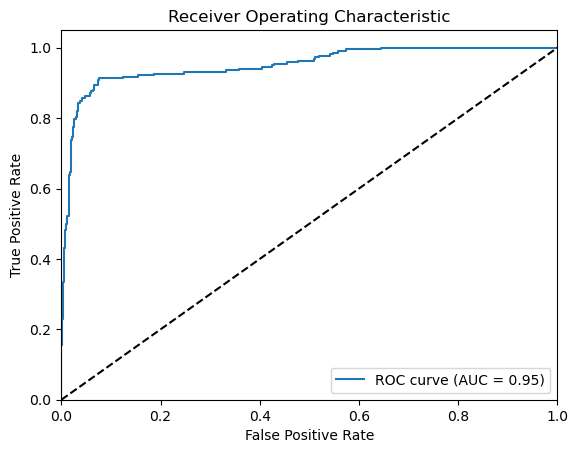

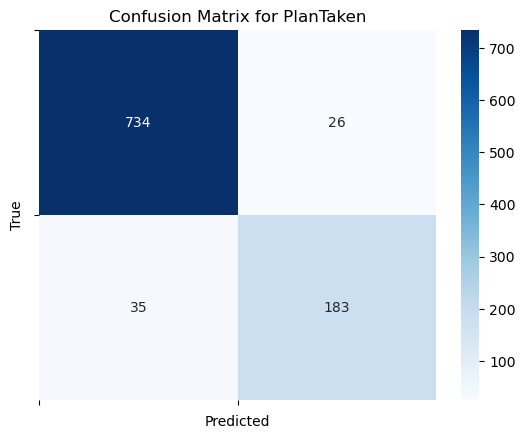

In [ ]:
def build_SVM_model(X_train, X_test, y_train, y_test):
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    svm_model = SVC(kernel='rbf', C=13.0, probability=True)
    svm_model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test)
    y_prob = svm_model.predict_proba(X_test)[:, 1]
    
    show_auc_under_roc(y_test, y_pred, y_prob)
    show_confusion_matrix(y_test, y_pred)

    return svm_model, y_pred, y_prob

model, y_pred, y_prob = build_SVM_model(X_train, X_test, y_train, y_test)

# Sentivity Analysis

### Global Sensitivity Analysis

<generator object <genexpr> at 0x289ec7d80>


### Sensitivity of core features

RuntimeError: 
        Incorrect number of samples in model output file.
        Confirm that calc_second_order matches option used during sampling.

In [ ]:
N = 2 ** 10
 
problem = {
    'num_vars': 12,  # Number of features in your dataset
 
    'names': ['Age', 'CityTier', 'DurationOfPitch', 'NumberOfPersons',
              'NumberOfFollowups', 'PreferredServiceStar', 'NumberOfUpgrades',
              'iPhone', 'PitchSatisfactionScore', 'PhoneContract',
              'NumberOfChildren', 'MonthlyIncome'],
 
    'bounds': [
        [18, 61],  # Age
        [1, 3],    # CityTier
        [5, 127],  # DurationOfPitch
        [1, 5],    # NumberOfPersons
        [1, 6],    # NumberOfFollowups
        [3, 5],    # PreferredServiceStar
        [1, 22],   # NumberOfUpgrades
        [0, 1],    # iPhone (Assuming it's binary, change if it's categorical)
        [1, 5],    # PitchSatisfactionScore
        [0, 1],    # PhoneContract (Assuming it's binary)
        [0, 3],    # NumberOfChildren
        [1000, 98678],  # MonthlyIncome
    ]
}

from SALib.analyze import sobol as sobol_analyze

param_values = saltelli.sample(problem, 10)

# Evaluate the model with different parameter values
model_outputs = []
for params in param_values:
    # Modify the model with the sampled parameter values
    modified_X_test = X_test.copy()  # Make a copy of X_test to avoid modifying the original data
   
    # Modify each feature separately
    for i in range(problem['num_vars']):
        modified_X_test[:, i] *= params[i]
 
    y_pred = model.predict(modified_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_outputs.append(accuracy)

/var/folders/xn/1g0gv8vj4qbf5q8q7ch4p7_m0000gn/T/ipykernel_9180/4232638992.py:29: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 10)
/Users/joelraju/anaconda3/lib/python3.11/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10) is equal to `2^n`.
        
  warnings.warn(msg)


### LIME

In [ ]:
def build_lime_explainer(df, X_train):
  explainer = lime_tabular.LimeTabularExplainer(X_train, mode="regression", feature_names=df.columns)
  explainer

build_lime_explainer(df, X_train)

IndexError: list index out of range